# (De)Crappify

### Angélica Nayeli Rivas Bedolla

## Introducción

$Decrappify$ es un método de $deep$ $learning$ implementado por fastai en PyTorch eficientar el entrenamiento de las $GAN$s que son dificiles de implementar por la necesidad de grandes volumenes de datos para su entrenamiento. Para ello se pensó en una alternativa que funciona llamada $NoGAN$ que consta de lo siguiente:
1. A un conjunto de datos se le aplica $Crappify$ al agregarle texto, cambiando la resolución, etc.
2. Se pasa por una Red Neuronal de $Decrappify$ :

    1. Pre-entrenar el generador.
    2. Guardar imagenes generadas por el generador pre-entrenado.
    3. Pre-entrenar el crítico (discriminador) como un clasificador binario.
    4. Entrenar el Generador y Crítico juntos.

# Objetivo

Crear una aplicación en la cual el usuario pueda dibujar encima de una fotogrfía de personas elegida para pasarla por una red neuronal que pueda recrear la fotografía original.

## Metodología

Con el uso de Google Cloud para tener acceso a una GPU y con el uso de librerías para Python como PIL y PyQt5 fastai, PIL y tqdm, para crear el crappify, y, Fastai, torch, entre otros para crear el decrappify. Usando Imágenes de StyleGAN con resolución de __256x256__.

La interfaz se creo con base al proyecto de Editor de Fotos Simple **[12 en interfaz]** y el Paint bitmap **[11 en interfaz]** en el cual se trabaja con layouts y pixmap de PyQt5, y librerías draw y PIL como herramientas principales para crear la imagen modificada por el usuario.

El crappify se creó con el uso de PIL para dibujar las figuras piezas de pastel, arcos, arcos cerrados, elipses, líneas y polígonos con posiciones y tamaños aleatorios, mayor información en el notebook correspondiente.

Para el decrappify se siguieron los pasos marcados en el notebook de Decrappify de Miguel Raggi [1 en referencia], el tutorial de Julia Wu [2 en referencia] y seccionado como el artículo de Fastai  [4 en referencia] se obtiene lo siguiente:

1. **Pre-entrenar el generador**.
Se optó por experimentar con las funciones de perdida propuesto en ambas referencias, l1 y l2 se decidió por la implementación del profesor llamado l1_loss_flat.
De forma convencional se lleva a cabo con perceptual loss (feature loss) el cual intenté llevar a cabo de 2 maneras, una descargando una implementación que creo es la opción seguida por el profesor y la segunda al seguir un proyecto de fastai donde lo implementan con Torch.

2. **Guardar imágenes generadas por el generador pre-entrenado**.

3. **Pre-entrenar el crítico (discriminador) como un clasificador binario**.
Se entrena como discriminador de imagenes reales o falsas que se obtuvieron del punto 2, así se mejora el generador basado en un mejor crítico.
La función de pérdida usada fue la misma en ambos BinaryCrossEntropy así que no experimente y me fui por ello.

4. **Entrenar el Generador y Crítico juntos**.
Cada iteración duró mas que los anteriores entrenamientos pero necesitó pocas iteraciones.

### Librerías

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.vision as fv
import fastai.vision.gan as fgan
from pathlib import Path
from shutil import copyfile
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as utils
import PIL
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm_notebook as tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np

### Funciones

In [3]:
def load_data(img_size, batch_size, tfms, path_good, path_crappy, amount=1.): # Referencia 1
    data = (fv.ImageImageList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .random_split_by_pct(0.2)
            .label_from_func(lambda x: path_good/x.relative_to(path_crappy))
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats, do_y=True))
    data.c = 3
    return data

In [4]:
def l1_loss_flat(a,b): # Referencia 1
    return F.l1_loss(a.squeeze(), b.squeeze())

In [5]:
def create_learner(data): # Referencia 1
    return fv.unet_learner(data,
                           fv.models.resnet34,
                           blur=True,
                           norm_type=fai.NormType.Weight,
                           self_attention=True,
                           y_range=(-3.,3.),
                           loss_func=l1_loss_flat,
                           metrics=[l1_loss_flat],
                           wd=1e-2)

In [7]:
def save_preds(dl, gen_images): # Referencia 1
    i=0
    names = dl.dataset.items
    
    for b in tqdm(dl):
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(gen_images/names[i].name )
            i += 1

In [8]:
def save_model(learn, iteration, accuracy, lr):
    path = Path(f'../models/{iteration}')
    path.mkdir(exist_ok=True)
    torch.save(learn.model.state_dict(), path/f'{lr}-{accuracy}.pth')

def load_model(learn, iteration, accuracy, lr):
    learn.model.load_state_dict(torch.load(f'../models/{iteration}/{lr}-{accuracy}.pth'))

In [9]:
def load_data_crit(classes, img_size, bs, amount=1.): # Referencia 1 y 2
    data = (fv.ImageList.from_folder(Path("../Images"),include=classes)
            .filter_by_rand(amount)
            .random_split_by_pct(0.1, seed=666)
            .label_from_folder(classes=classes)
            .transform(tfms, size=img_size)
            .databunch(bs=bs)
            .normalize(fv.imagenet_stats))
    data.c = 3
    return data

def create_critic_learner(data, metrics): # Referencia 1 y 2
    loss_gan = fgan.AdaptiveLoss(nn.BCEWithLogitsLoss())
    return fai.Learner(data, fgan.gan_critic(), metrics=metrics, loss_func=loss_gan, wd=1e-2)

### 1. Pre-entrenar el generador. 

In [10]:
path_good   = Path("../Images/StyleGAN") # neural network
path_crappy = Path("../Images/crapifiadas") # neural network
iteracion   = Path("02") #nuevo folder para la iteracion
crappy_path = path_crappy/iteracion

In [11]:
tfms = fv.get_transforms(do_flip = False,
                         max_zoom = 1.15,
                         max_lighting = 0.3,
                         max_warp = 0.1,
                         p_affine = 0.5,
                         p_lighting = 0.8
                        )

In [11]:
data = load_data(256, 2, tfms, path_good, crappy_path, 0.1)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


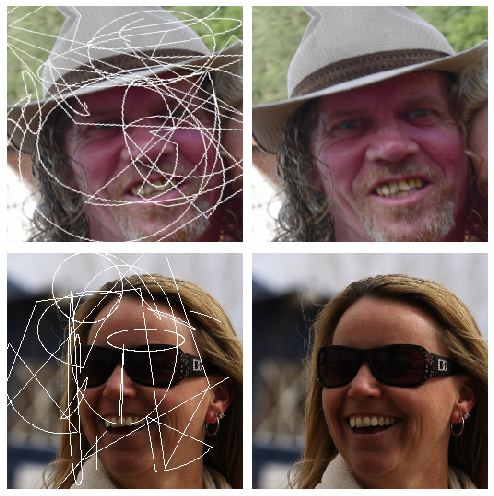

In [14]:
data.show_batch(rows=2, figsize=(7,7))

In [13]:
learn = create_learner(data)

#### Entrenamientos

In [84]:
gc.collect();

In [ ]:
learn.lr_find();
learn.recorder.plot()

In [ ]:
lr = 5e-4
learn.fit_one_cycle(50, max_lr=slice(lr/64,lr),pct_start=0.7, div_factor=1)

Resultados al primer entrenamiento

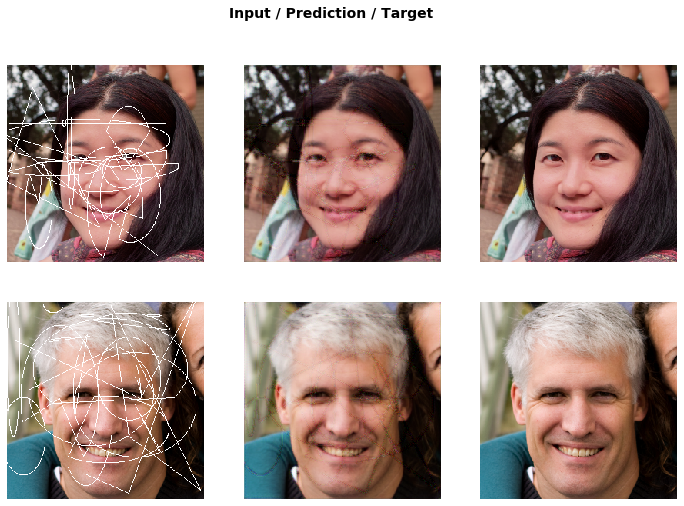

In [14]:
learn.show_results(rows=2)

In [87]:
save_model(learn, iteracion, "007", lr)

In [81]:
load_model(learn, iteracion, "103", 1e-4)

In [ ]:
learn.lr_find();
learn.recorder.plot()

In [ ]:
lr = 1e-5
learn.fit_one_cycle(5, max_lr=slice(lr))#, div_factor=0.8)

In [ ]:
learn.lr_find();
learn.recorder.plot()

In [ ]:
lr = 1e-4
learn.fit_one_cycle(1, max_lr=slice(lr), div_factor=1)

In [35]:
save_model(learn, iteracion, 4, lr)

In [ ]:
learn.lr_find();
learn.recorder.plot()

In [ ]:
lr = 1e-3
size = 256
for freeze in range(1, len(learn.layer_groups)+1):
    learn.data = load_data(size, 8, tfms, path_good, crappy_path, 0.3)
    learn.freeze_to(-freeze)
    print(f"{size} at freeze level {freeze}")
    gc.collect()
    torch.cuda.empty_cache()
    learn.fit_one_cycle(1, max_lr=slice(lr/64,lr),pct_start=0.7)
    save_model(learn, iteracion, str(freeze)+"deepth", lr)
    lr *= 0.8

In [23]:
save_model(learn, iteracion, 3, lr)

Resultado al final de la primer etapa.

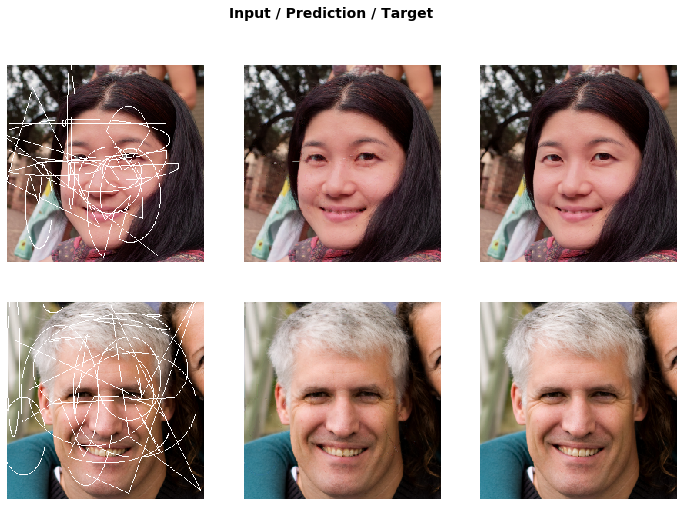

In [20]:
learn.show_results(rows=2)

# Perceptual Loss (feature loss) *FAIL* :c

Error del primer método usando la implementación encontrada por Google.

In [27]:
learn.lr_find(); learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: unsupported format string passed to Tensor.__format__

Error del segundo método usando la implementación sugerida por fastai que usa Torch.

In [49]:
learn.data = load_data(256, 8, tfms, path_good, crappy_path, 0.1)

AttributeError: 'int' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

### 2. Guardar imagenes generadas por el generador pre-entrenado.

In [11]:
gen_images = Path("../Images/generated")

In [24]:
save_preds(learn.data.train_dl, gen_images) #para GAN

### 3. Pre-entrenar el crítico (discriminador) como un clasificador binario.

In [ ]:
learn = None
gc.collect();

In [13]:
data_gan = load_data_crit(["generated", 'StyleGAN'], img_size=256, bs=4, amount=0.2)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


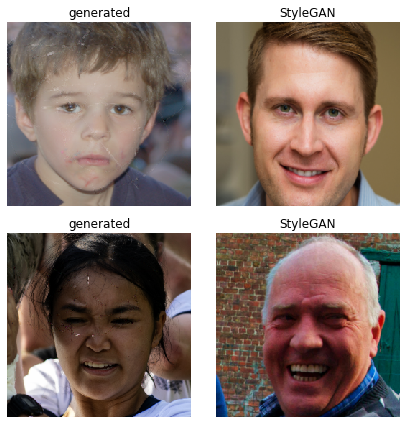

In [24]:
data_gan.show_batch(rows=3, ds_type=fai.DatasetType.Train, imgsize=3) # Referencia 2

In [14]:
gc.collect(); torch.cuda.empty_cache()

In [16]:
learn_gan = create_critic_learner(data_gan, fgan.accuracy_thresh_expand)

In [18]:
learn_gan.load('../../models/02/2e-5_-1critic-pretrain');

In [ ]:
for i in range(numerito):#numerito es el numero de epocas que se quiera
    #learn_gan.lr_find(); learn_gan.recorder.plot()
    lr = input()
    learn_gan.fit_one_cycle(1, float(lr))
    learn_gan.save(f'../../models/02/{lr}_{i}critic-pretrain')
    
    if i<numerito-1:
        learn_gan.data = load_data_crit(["generated", 'StyleGAN'], bs=8, img_size=256, amount=0.2/i+1)

In [ ]:
learn_gan.show_results(rows=2)

### 4. Entrenar el Generador y Crítico Juntos

In [12]:
gc.collect(); torch.cuda.empty_cache()

In [13]:
data_crit = load_data_crit(["generated", 'images1024x1024'], bs=4, img_size=256, amount=0.2)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [14]:
data_gen = load_data(256, 2, tfms, path_good, crappy_path, 0.2)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [15]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('../../models/02/3e-6_3critic-pretrain')

In [16]:
learn_gen = create_learner(data_gen)
load_model(learn_gen, "01", 3, 0.0005120000000000001)

In [17]:
switcher = fai.partial(fgan.AdaptiveGANSwitcher, critic_thresh=0.65, gen_thresh=0.8)

learn = fgan.GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,40.), show_img=True, switcher=switcher, opt_func=fai.partial(torch.optim.Adam, betas=(0.,0.99)), wd=1e-2)

learn.callback_fns.append(fai.partial(fgan.GANDiscriminativeLR, mult_lr=5.))

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit(1,3e-4)

In [26]:
learn.save(f'../../../../models/03/{3e-4}_juntos')

### Resultados

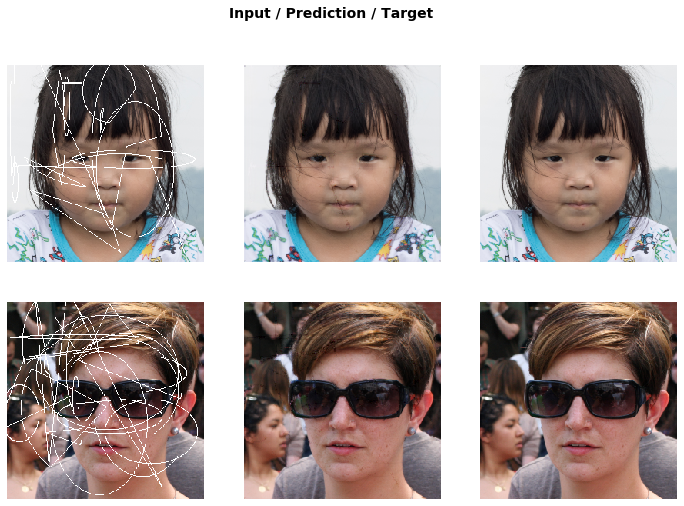

In [28]:
learn.show_results(rows=2)

No se pudo conectar interfaz con red neuronal porque mi laptop no cuenta con GPU y no sé usar **__GCloud__** fuera del notebook.

## Conclusiones

1. Mejoraría si mi implementación tuviera el feature loss.
2. El método NoGAN funciona chido.

## Referencias

1. Miguel Raggi. (2019). [05.DecrappifyFaces.ipynb](https://github.com/mraggi/NeuralSensei/blob/master/05.DecrappifyFaces.ipynb).

2. Julia Wu. (2019). [Fast.ai Lesson 7 of 7: Resnet, UNet, GANs](https://medium.com/@juliawu/fast-ai-lesson-7of-7-resnet-unet-gans-245960585fd2).

3. Richard Zhang. (2018). [Perceptual Similarity](https://github.com/richzhang/PerceptualSimilarity).

4. Fastai Courses. [Decrappification, DeOldification, and Super Resolution](https://www.fast.ai/2019/05/03/decrappify/).

5. Beckman, S., Howard, J., Gugger, S.. (2019). [lesson7-superres.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres.ipynb).

6. Thomas, R., Clungu, Puderer, J., HOward, J., Allentfung, Desconocido. (2017). [vgg16bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py).

7. [Fastai Documentation](https://docs.fast.ai/).